#### Mount Drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
% cd '../gdrive/My Drive/Hubble/Colab Notebooks/investigate_undistortion/'

/gdrive/My Drive/Hubble/Colab Notebooks/investigate_undistortion


#### Imports

In [0]:
!pip3 install ffmpeg

In [0]:
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import pandas as pd


#### Notes/Findings:
-  OpenSfM values for k1/k2 is constant throughout a recontstruction, however is inconsistent between reconstructions: https://drive.google.com/open?id=1MWzwOdQayDcW_RmgkWRI2ngiLlwsEcJB
  -  OpenSfM outputs focal and focal_prior, currently we use the value for 'focal'
-  There is a difference in undistortion between the OpenSfM and ffmpeg methods for the same k-parameters.
  -  Original: https://drive.google.com/open?id=1yLK1DZXXFM0DMT8DCodf_R8wI0WdSMC6
  -  OpenSfM Undistortion: https://drive.google.com/open?id=1ajsx9LGS91pFcpRh-UdDI0csY4U9O07X
  -  ffmpeg Undistortion: https://drive.google.com/open?id=112dtpKrrj4N2uKxyk0aagUTc2n3yrBJa 
  -  k-parameters for this example are in the dataframe below, the summed distance between the two is 13992544 (grayscale). Average pixel diff is ~5
-  We can perform the undistortion for semantically segmented images:
  -  Original: https://drive.google.com/open?id=1YnA1iT9iIYQRNzF7XO_OGB9mMM-9Uh6r
  -  ffmpeg: https://drive.google.com/open?id=1J279UbPzAruEkgeK0-tLWQV2ndGwNrrG 
  -  CV2 Output: https://drive.google.com/open?id=1GTa4QUrxeUVmEDTdysRQlIMq_5fS5N23
-  We can replicate the OpenSfM undistortion using the CV2 method below:
  -  OpenSfM Undistortion: https://drive.google.com/open?id=1ajsx9LGS91pFcpRh-UdDI0csY4U9O07X
  -  CV2 Output: https://drive.google.com/open?id=1CSLob--lEo6shMAb7yG84K8wDRhI-aqJ 
  -  Diff: 775973, Average Pixel Diff: 0.281

#### Camera Data

In [0]:
# Ref: http://argus.web.unc.edu/camera-calibration-database/

title = ["Camera", "mode", "focal_length", "width", "height", "cx", "cy", "A", "k1", "k2", "t1", "t2", "k3"]
row1 = ["GoPro Hero3 White", "1080p-30fps-wide",	1230,	1920,	1080,	960,	540,	1,	-0.32,	0.126,	0,	0,	0]
row2 = ["GoPro Hero4 Black", "1080p-120fps-wide",	900,	1920,	1080,	959.5,	539.5,	1,	-0.25,	0.06,	0,	0,	0]
row3 = ["GoPro Hero4 Black",	"1440p-80fps-wide",	883,	1920,	1440,	959.5,	719.5,	1,	-0.256,	0.081,	0,	0,	0]
row4 = ["OpenSfm", "-",1347, 1920, 1440, 960, 720, 1, -0.2883, 0.0622, 0, 0, 0]


camera_df = pd.DataFrame([row1, row2, row3, row4], columns=title)
camera_df

,Camera,mode,focal_length,width,height,cx,cy,A,k1,k2,t1,t2,k3
0,GoPro Hero3 White,1080p-30fps-wide,1230,1920,1080,960.0,540.0,1,-0.3200,0.1260,0,0,0
1,GoPro Hero4 Black,1080p-120fps-wide,900,1920,1080,959.5,539.5,1,-0.2500,0.0600,0,0,0
2,GoPro Hero4 Black,1440p-80fps-wide,883,1920,1440,959.5,719.5,1,-0.2560,0.0810,0,0,0
3,OpenSfm,-,1347,1920,1440,960.0,720.0,1,-0.2883,0.0622,0,0,0


#### CV2 Undistort (Attempting to replicate the OpenSfM undistortion)

Credit: https://raw.githubusercontent.com/cdw/undivid/master/undistort.py

In [0]:
row_idx = 3

row_series = camera_df.iloc[row_idx]

# set parameters
FC = np.repeat(row_series["focal_length"], 2) # Focal Lengths
CC = [row_series["width"]/2, row_series["height"]/2] # principle points (usually half width/height)
KC = [row_series["k1"], row_series["k2"], row_series["t1"], row_series["t2"], row_series["k3"]] # distortion coeffs


In [0]:
def create_matrix_profile(fc, cc, kc):
    """Create the camera matrix and distortion profile.

    Take in th e focal lengths, principle points, and distortion coefficients
    and return the camera matrix and distortion coefficients in the form
    OpenCV needs.
    Takes:
        fc - the x and y focal lengths [focallength_x, focallength_y]
        cc - the x and y principle points [point_x, point_y]
        kc - the distortion coefficients [k1, k2, p1, p2, k3]
    Gives:
        cam_matrix - the camera matrix for the video
        distortion_profile - the distortion profile for the video
    """
    fx, fy = fc
    cx, cy = cc
    cam_matrix = np.array([[fx,  0, cx],
                           [ 0, fy, cy],
                           [ 0,  0,  1]], dtype='float32')
    distortion_profile = np.array(kc, dtype='float32')
    return cam_matrix, distortion_profile

#### Undistortion

In [0]:
# Load Image
img = cv2.imread('screenshots/semseg_test.png')

In [0]:
# Undistort
cam_matrix, profile = create_matrix_profile(FC, CC, KC)
frame =  cv2.undistort(img, cam_matrix, profile)

# cv2.imwrite("screenshots/ex_self_semseg_undistort.jpg", frame)

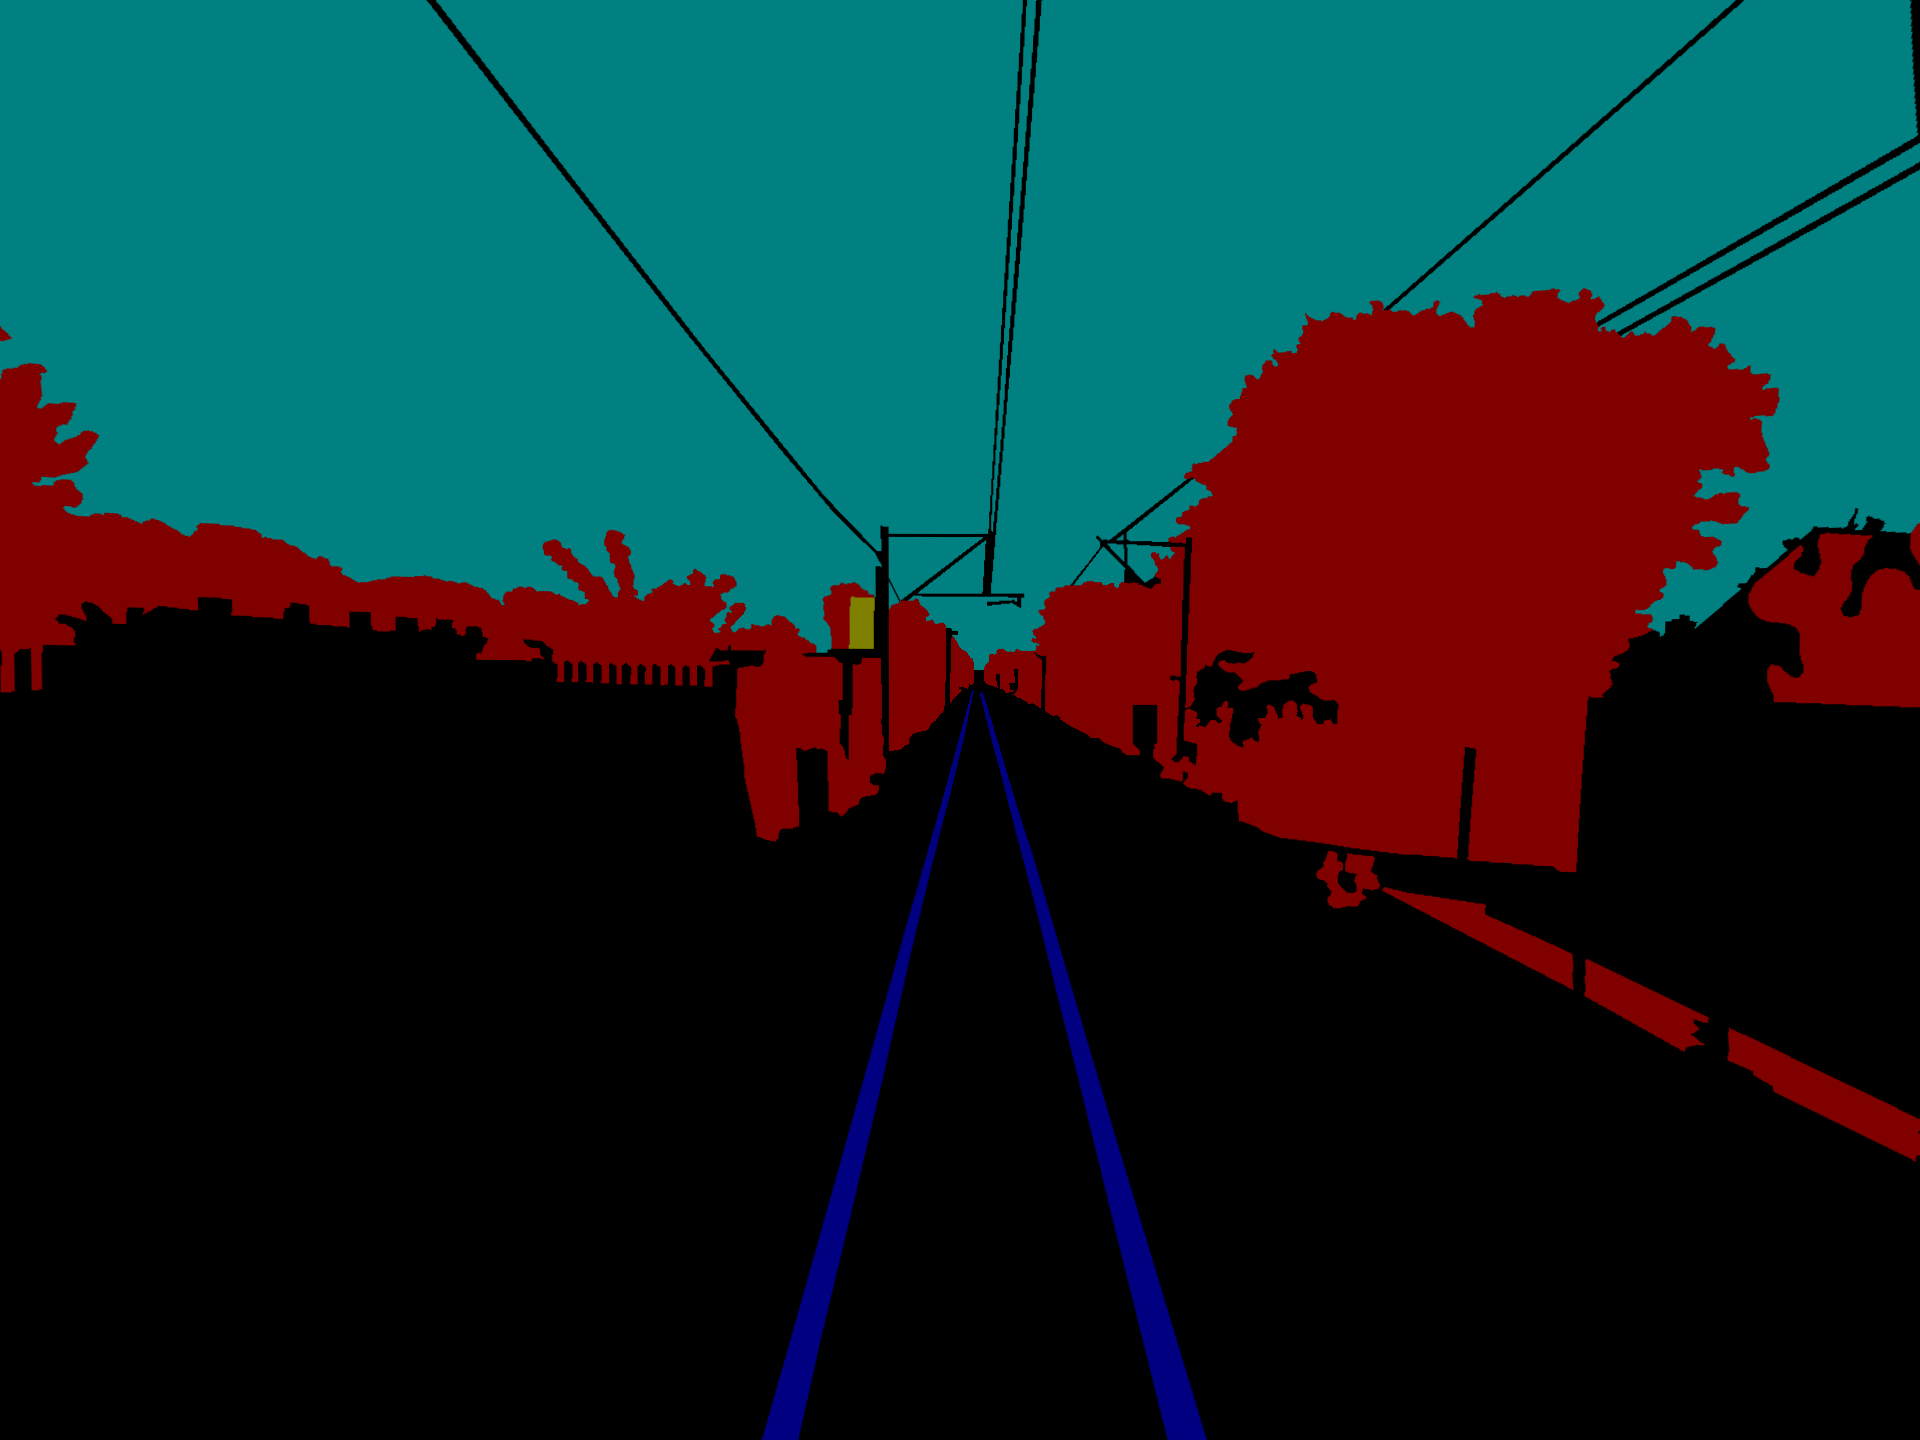

In [0]:
cv2_imshow(frame)

#### Image Comparison

In [0]:
opensfm_undistortion = cv2.imread("./screenshots/ex_opensfm_output.jpg",0)
ffmpeg_undistortion = cv2.imread("./screenshots/ex_ffmpeg_output.jpg",0)

ex_undistortion = cv2.imread("./screenshots/ex_self_undistort.jpg", 0)

cv2_sum_subtract = np.sum(cv2.subtract(opensfm_undistortion,ex_undistortion))
print(f"Sum of Distance between OpenSfM undistortion and Ffmpeg \
undistortion for the same k-parameters: {cv2_sum_subtract}")

avg_pixel_diff = cv2_sum_subtract/(1440*1920)
print(f"Average pixel Difference: {avg_pixel_diff}")

Sum of Distance between OpenSfM undistortion and Ffmpeg undistortion for the same k-parameters: 775973
Average pixel Difference: 0.2806615306712963
